In [29]:
from utils import *
from collections import deque
from planning import *
import copy 

In [30]:
def findShortestPath_test(start_pos, end_pos, info, env, all_door_unlock=False):
    h, w = info['height'], info['width']
    door_pos = info["door_pos"]
    if isinstance(door_pos, list):
        door_list = [list(arr) for arr in door_pos]
    else:
        door_list = [list(door_pos)]
        
    # init dp matrix
    dp = np.full((h ,w), float("inf"))
    dp[swap(start_pos)] = 0

    # init parent matrix (for tracking path)
    # note: position in parent is the previous pos of cur in env coordinate
    parent = np.full((h ,w, 2), [-1,-1])

    # nodes need to be visited next iteration
    q = deque()
    q.append(start_pos)

    # size ensure to process nodes added in same iteration at the same time
    size = len(q)
    dir = [[1,0], [-1,0], [0,1], [0,-1]]
    while True:
        # print(q)
        prev_dp = dp.copy()
        for _ in range(size):
            # print(prev_dp)
            cur_pos = q.popleft()
            # print(cur_pos)
            for d in dir:
                x = cur_pos[0] + d[0]
                y = cur_pos[1] + d[1]
                
                # check boundary
                if y < 0 or y >= h or x < 0 or x >= w:
                    continue
                
                # if there's a way (assume door cant pass)
                # TODO: need to consider door open/lock
                if env.grid.get(x, y) == None or env.grid.get(x, y).type != "wall":
                    # need to check door lock (no key)
                    if not all_door_unlock:
                        # check whether is door
                        if [x, y] in door_list:
                            door = env.grid.get(x, y)
                            if door.is_locked:
                                continue
                    
                    # if get key, no need to check door lock
                    if dp[y][x] > dp[swap(cur_pos)]+1:
                        dp[y][x] = dp[swap(cur_pos)]+1
                        parent[y][x] = cur_pos
                    if (x, y) not in q:
                        q.append((x, y))

        size = len(q)

        if (checkVal(prev_dp, dp)):
            break

    cost = dp[swap(end_pos)]  
    return cost, dp, parent

In [3]:
import glob
fname = glob.glob(os.path.join("envs/known_envs/", '*.env'))
print(fname)

['envs/known_envs/doorkey-8x8-shortcut.env', 'envs/known_envs/example-8x8.env', 'envs/known_envs/doorkey-8x8-normal.env', 'envs/known_envs/doorkey-6x6-direct.env', 'envs/known_envs/doorkey-6x6-normal.env', 'envs/known_envs/doorkey-8x8-direct.env', 'envs/known_envs/doorkey-5x5-normal.env', 'envs/known_envs/doorkey-6x6-shortcut.env']


In [ ]:
# test for known env (old)
for i in range(len(fname)):
    env_path = fname[i]
    env, info = load_env(env_path)  # load an environment
    # plot_env(env)
    agent_pos = info['init_agent_pos']
    goal_pos = info['goal_pos']
    key_pos = info["key_pos"]
    door_pos = info["door_pos"]

    cost, path = getMinPath(env, info)
    print(f"Cost: {cost}")
    control, control_text = getMotion(env, path, info)

    fn = env_path.split("/")[-1].split(".")[0]
    gif_path = f"./gif/{fn}.gif"
    draw_gif_from_seq(control, load_env(env_path)[0], gif_path)  # draw a GIF & save

In [4]:
def load():
    env_folder = "./envs/random_envs"
    env, info, env_path = load_random_env(env_folder)
    return env, info, env_path

In [30]:
fname_rand = glob.glob(os.path.join("envs/random_envs/", '*.env'))
len(fname_rand)

36

In [31]:
def getMinPath_test(env, info):
    agent_pos = info['init_agent_pos']
    goal_pos = info['goal_pos']
    
    key_pos = list(info["key_pos"])
    dir = [[1,0],[-1,0],[0,1],[0,-1]]
    key_candidate = [[key_pos[0]+d[0], key_pos[1]+d[1]] for d in dir]

    # direct
    cost_dir, dp_dir, parent_dir = findShortestPath_test(agent_pos, goal_pos, info, env)

    # get key, consider 4 diff key candidate position
    cost_best_temp = float("inf")
    for key_cand_pos in key_candidate:
        cost_key, dp_key, parent_key = findShortestPath_test(agent_pos, key_cand_pos, info, env, all_door_unlock=False)
        cost_goal, dp_goal, parent_goal = findShortestPath_test(key_cand_pos, goal_pos, info, env, all_door_unlock=True)
        if cost_key + cost_goal < cost_best_temp:
            cost_best_temp = cost_key + cost_goal
            key_pos_best = key_cand_pos
            cost_key_best, dp_key_best, parent_key_best = cost_key, dp_key, parent_key
            cost_goal_best, dp_goal_best, parent_goal_best = cost_goal, dp_goal, parent_goal

    cost_key_total = cost_key_best + cost_goal_best

    cost = -1
    path = []

    if (cost_dir <= cost_key_total):
        cost = cost_dir
        path += findPathFromParent(parent_dir, agent_pos, goal_pos)
    else:
        cost = cost_key_total
        path += findPathFromParent(parent_key_best, agent_pos, key_pos_best)
        if len(path) != 0:
            path += [tuple(key_pos), path[-1]]
        else:
            path += [tuple(key_pos), agent_pos]
        path += findPathFromParent(parent_goal_best, key_pos_best, goal_pos)
    return cost, path

In [ ]:
# test for known env
for i in range(len(fname)):
    env_path = fname[i]
    env, info = load_env(env_path)  # load an environment
    fn = env_path.split("/")[-1].split(".")[0]
    print(fn)

    plot_env(env)
    cost, path = getMinPath_test(env, info)
    # print(cost)
    # print(path)
    control, control_text = getMotion(env, path, info)
    print(control_text)
    
    # gif_path = f"./gif/{fn}_test.gif"
    # draw_gif_from_seq(control, load_env(env_path)[0], gif_path)  # draw a GIF & save

In [ ]:
import copy 
env_path = fname[0]
env, info = load_env(env_path)  # load an environment
env_copy = copy.deepcopy(env)
fn = env_path.split("/")[-1].split(".")[0]
print(fn)

plot_env(env)
cost, path = getMinPath_test(env, info)
# print(cost)
# print(path)
control, control_text = getMotion(env, path, info)
print(control_text)
plot_env(env_copy)

In [34]:
# test for random env
env, info, env_path = load()
env_copy = copy.deepcopy(env)
fn = env_path.split("/")[-1].split(".")[0]
print(fn)

DoorKey-8x8-11


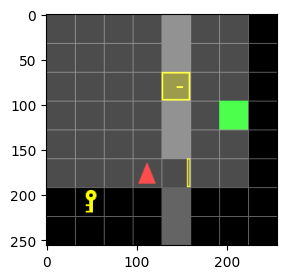

[(4, 5), (5, 5), (6, 5), (6, 4), (6, 3)]
['TR', 'UD', 'MF', 'TR', 'MF', 'TR', 'MF', 'TR', 'MF', 'TR', 'MF']


In [33]:
plot_env(env)
cost, path = getMinPath(env, info)
# print(cost)
print(path)
control, control_text = getMotion(env, path, info)
print(control_text)

gif_path = f"./gif/{fn}_rand_.gif"
# draw_gif_from_seq(control, env_copy, gif_path)  # draw a GIF & save

In [10]:
key_pos = info["key_pos"]
door_pos = info["door_pos"]
print(key_pos)
print(door_pos)

[1 6]
[array([4, 2]), array([4, 5])]


In [15]:
door_pos

[array([4, 2]), array([4, 5])]

In [16]:
key_pos = info["key_pos"]
door_pos = info["door_pos"]
if isinstance(door_pos, list):
    door_list = [list(arr) for arr in door_pos]
else:
    door_list = [list(door_pos)]
control_all = []
text_all = []
i = 0

while i < len(path):
    control = []
    text = []
    agent_pos = env.agent_pos
    next_pos = path[i]
    # print(next_pos)

    delta_pos = np.subtract(next_pos, agent_pos)
    # print(f"delta_pos: {delta_pos}")

    cur_dir = env.dir_vec
    # print(f"cur_dir: {cur_dir}")

    if (cur_dir == delta_pos).all():
        control += [MF]
        text += ["MF"]
    elif (delta_pos == -1 * cur_dir).all():
        control += [TR, TR, MF]
        text += ["TR", "TR", "MF"]
    else:
        if np.cross(cur_dir, delta_pos).item() == -1:
            control += [TL, MF]
            text += ["TL", "MF"]
        else:
            control += [TR, MF]
            text += ["TR", "MF"]

    if list(next_pos) in door_list:
        control.pop()
        control += [UD, MF]
        text.pop()
        text += ["UD", "MF"]
    
    if (next_pos == key_pos).all():
        # key -> PK, no need to MF
        # not sure to pop
        control.pop()
        control += [PK]
        text.pop()
        text += ["PK"]
        i += 1
    
    i += 1
    control_all += control
    text_all += text

    for u in control:
        step(env, u)
        # plot_env(env)


In [17]:
text_all

['TR', 'UD', 'MF', 'TR', 'MF', 'TR', 'MF', 'TR', 'MF', 'TR', 'MF']

In [117]:
agent_pos = info['init_agent_pos']
goal_pos = info['goal_pos']
key_pos = info["key_pos"]
start_pos = agent_pos
end_pos = goal_pos
all_door_unlock = False
key_pos = list(info["key_pos"])
dir = [[1,0],[-1,0],[0,1],[0,-1]]
key_candidate = [[key_pos[0]+d[0], key_pos[1]+d[1]] for d in dir]

In [118]:
# direct
cost_dir, dp_dir, parent_dir = findShortestPath_test(agent_pos, goal_pos, info, env)

# get key, consider 4 diff key candidate position
cost_best = float("inf")
for key_cand_pos in key_candidate:
    cost_key, dp_key, parent_key = findShortestPath_test(agent_pos, key_cand_pos, info, env, all_door_unlock=False)
    cost_goal, dp_goal, parent_goal = findShortestPath_test(key_cand_pos, goal_pos, info, env, all_door_unlock=True)
    if cost_key + cost_goal < cost_best:
        cost_best = cost_key + cost_goal
        key_pos_best = key_cand_pos
        cost_key_best, dp_key_best, parent_key_best = cost_key, dp_key, parent_key
        cost_goal_best, dp_goal_best, parent_goal_best = cost_goal, dp_goal, parent_goal

In [119]:
cost_key_total = cost_key_best + cost_goal_best

cost = -1
path = []

if (cost_dir <= cost_key_total):
    cost = cost_dir
    path += findPathFromParent(parent_dir, agent_pos, goal_pos)
else:
    cost = cost_key_total
    path += findPathFromParent(parent_key_best, agent_pos, key_pos_best)
    if len(path) != 0:
        path += [tuple(key_pos), path[-1]]
    else:
        path += [tuple(key_pos), agent_pos]
    path += findPathFromParent(parent_goal_best, key_pos_best, goal_pos)

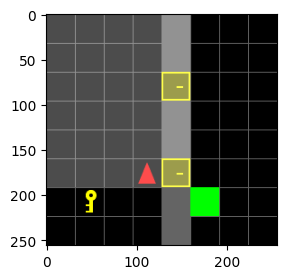

[(2, 5), (2, 6), (1, 6), (2, 6), (3, 6), (3, 5), (4, 5), (5, 5), (5, 6)]


In [120]:
plot_env(env)
print(path)